# Calculate Surface roughness from Smooth (aka Rufmod) experiments

* **Description**: Reads in and creates monthly average
* **Input data**: Rufmod output in timeseries format
* **Output data**: png with drag figure
* **Creator**: Alice DuVivier
* **Date**: August 2022

The rufmod experiments were performed where the sea ice roughness over Arctic sea ice regions was set to be equal to what it would be over open ocean. This is to better understand ice-atmosphere coupling, processes, and feedbacks. The name of the experiments is "rufmod" but they include smoother ice and will be called "smooth" below.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec
import pop_tools
from datetime import timedelta
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xesmf as xe

import dask
import intake
from distributed import Client
from ncar_jobqueue import NCARCluster

/glade/work/duvivier/miniconda3/envs/analysis2/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
# spin up dask cluster

import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=2, # The number of cores you want
    memory='32 GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    #resource_spec='select=1:ncpus=2:mem=256GB', # Specify resources
    project='P93300665', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(32)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:45058,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Manually set variables

In [4]:
# list the variables to load
var_in_1 = 'sidragtop'
var_in_2 = 'aice'

## Load "smooth" experiments

In [5]:
# Load "rufmod" data
#choose cases and data paths
case1 = 'b.e21.BSSP370.f09_g17.rufmod.001'
case2 = 'b.e21.BSSP370.f09_g17.rufmod.002'
case3 = 'b.e21.BSSP370.f09_g17.rufmod.003'
case4 = 'b.e21.BSSP370.f09_g17.rufmod.004'
case5 = 'b.e21.BSSP370.f09_g17.rufmod.005'

# set base directory where all data live
data_dir = '/glade/campaign/cesm/development/pcwg/projects/arctic_cyclones/rufmod_expts/'
# set individual data directories
data_dir1 = data_dir+case1+'/ice/proc/tseries/month_1/'
data_dir2 = data_dir+case2+'/ice/proc/tseries/month_1/'
data_dir3 = data_dir+case3+'/ice/proc/tseries/month_1/'
data_dir4 = data_dir+case4+'/ice/proc/tseries/month_1/'
data_dir5 = data_dir+case5+'/ice/proc/tseries/month_1/'

In [6]:
%%time
#reading in files
print("loading "+var_in_1)   
ds1_1 = []
ds2_1 = []
ds3_1 = []
ds4_1 = []
ds5_1 = []
my_files=sorted(glob.glob(data_dir1+case1+'.cice.h.'+var_in_1+'.*.nc'))
ds1_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir2+case2+'.cice.h.'+var_in_1+'.*.nc'))
ds2_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir3+case3+'.cice.h.'+var_in_1+'.*.nc'))
ds3_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')    
my_files=sorted(glob.glob(data_dir4+case4+'.cice.h.'+var_in_1+'.*.nc'))
ds4_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir5+case5+'.cice.h.'+var_in_1+'.*.nc'))
ds5_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')

print("loading "+var_in_2)   
ds1_2 = []
ds2_2 = []
ds3_2 = []
ds4_2 = []
ds5_2 = []
my_files=sorted(glob.glob(data_dir1+case1+'.cice.h.'+var_in_2+'.*.nc'))
ds1_2=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir2+case2+'.cice.h.'+var_in_2+'.*.nc'))
ds2_2=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir3+case3+'.cice.h.'+var_in_2+'.*.nc'))
ds3_2=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')    
my_files=sorted(glob.glob(data_dir4+case4+'.cice.h.'+var_in_2+'.*.nc'))
ds4_2=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir5+case5+'.cice.h.'+var_in_2+'.*.nc'))
ds5_2=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')

loading sidragtop
loading aice
CPU times: user 2.34 s, sys: 474 ms, total: 2.81 s
Wall time: 1min 17s


In [7]:
# concatenate them into a single array
futures_1 = xr.concat([ds1_1,ds2_1,ds3_1,ds4_1,ds5_1],dim='member_id')
futures_2 = xr.concat([ds1_2,ds2_2,ds3_2,ds4_2,ds5_2],dim='member_id')

In [8]:
# set member_id values
futures_1.member_id.values
futures_2.member_id.values

# assign member_id as coordinate array
futures_1.assign_coords({"member_id": futures_1.member_id.values})
futures_2.assign_coords({"member_id": futures_2.member_id.values})

<xarray.Dataset>
Dimensions:      (nj: 384, ni: 320, member_id: 5, time: 1032, nc: 5, nkice: 8, nksnow: 3, nkbio: 5, nvertices: 4, d2: 2)
Coordinates:
    TLON         (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    TLAT         (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan
    ULON         (nj, ni) float32 321.1 322.2 323.4 324.5 ... nan nan nan nan
    ULAT         (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan
  * time         (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id    (member_id) int64 0 1 2 3 4
Dimensions without coordinates: nj, ni, nc, nkice, nksnow, nkbio, nvertices, d2
Data variables: (12/21)
    NCAT         (member_id, time, nc) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    VGRDi        (member_id, time, nkice) float32 dask.array<chunksize=(1, 600, 8), meta=np.ndarray>
    VGRDs        (member_id, time, nksnow) float32 dask.array<chunksize=(1, 600, 3), meta=np.ndarray>
    VGRDb        (member_id, time, nkbio) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    tmask        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    tarea        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    ...           ...
    lont_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object dask.array<chunksize=(1, 600, 2), meta=np.ndarray>
    aice         (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.BSSP370.f09_g17.rufmod.001
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    comment:           All years have exactly 365 days
    comment2:          File written on model date 20150201
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2021-07-14 at 12:33
    io_flavor:         io_pio

In [9]:
futures_1

<xarray.Dataset>
Dimensions:      (nj: 384, ni: 320, member_id: 5, time: 1032, nc: 5, nkice: 8, nksnow: 3, nkbio: 5, nvertices: 4, d2: 2)
Coordinates:
    TLON         (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    TLAT         (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan
    ULON         (nj, ni) float32 321.1 322.2 323.4 324.5 ... nan nan nan nan
    ULAT         (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan
  * time         (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: nj, ni, member_id, nc, nkice, nksnow, nkbio, nvertices, d2
Data variables: (12/21)
    NCAT         (member_id, time, nc) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    VGRDi        (member_id, time, nkice) float32 dask.array<chunksize=(1, 600, 8), meta=np.ndarray>
    VGRDs        (member_id, time, nksnow) float32 dask.array<chunksize=(1, 600, 3), meta=np.ndarray>
    VGRDb        (member_id, time, nkbio) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    tmask        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    tarea        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    ...           ...
    lont_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object dask.array<chunksize=(1, 600, 2), meta=np.ndarray>
    sidragtop    (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.BSSP370.f09_g17.rufmod.001
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    comment:           All years have exactly 365 days
    comment2:          File written on model date 20150201
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2021-07-14 at 12:33
    io_flavor:         io_pio

In [10]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
futures_1.time_bounds.load().mean(dim='d2').sel(member_id=0)

<xarray.DataArray 'time_bounds' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00

In [11]:
futures_1['time'] = futures_1.time_bounds.load().mean(dim='d2').sel(member_id=0)
futures_2['time'] = futures_2.time_bounds.load().mean(dim='d2').sel(member_id=0)

In [12]:
futures_1.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00

In [13]:
sidragtop_smooth = futures_1[var_in_1]
aice_smooth = futures_2[var_in_2]

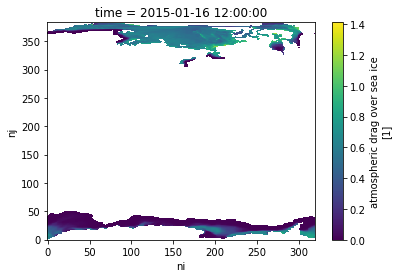

In [14]:
sidragtop_smooth.sel(member_id=0).isel(time=0).plot()

In [15]:
#mask just where aice>15%
sidragtop_masked_smooth = sidragtop_smooth.where(aice_smooth >= 0.15)

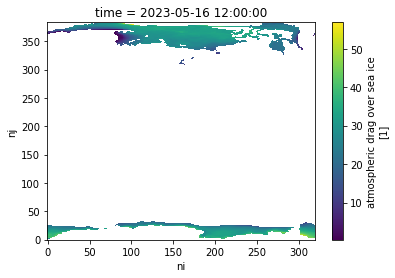

In [16]:
# test simple plot
sidragtop_masked_smooth.sel(member_id=0).isel(time=100).plot()

## Read the CESM-LE data 

We will use [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/), which is a data catalog tool.
It enables querying a database for the files we want, then loading those directly as an `xarray.Dataset`.

First step is to set the "collection" for the CESM-LE, which depends on a json file conforming to the [ESM Catalog Specification](https://github.com/NCAR/esm-collection-spec).

In [17]:
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'

cat = intake.open_esm_datastore(catalog_file)

/glade/work/duvivier/miniconda3/envs/analysis2/lib/python3.7/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [18]:
forcing = 'cmip6'  # do not want smbb data
expt = 'ssp370'

subset_1 = cat.search(variable=var_in_1, forcing_variant=forcing, experiment=expt )
subset_2 = cat.search(variable=var_in_2, forcing_variant=forcing, experiment=expt )


In [19]:
subset_2

,unique
component,1
stream,1
case,50
member_id,50
variable,1
start_time,9
end_time,9
time_range,9
long_name,1
units,1


In [ ]:
subset_2.df.head()

,component,stream,case,member_id,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment,forcing_variant,cesm_member_id,control_branch_year,cmip_experiment_id
0,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,aice,2015-01,2024-12,201501-202412,ice area (aggregate),1,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
1,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,aice,2025-01,2034-12,202501-203412,ice area (aggregate),1,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
2,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,aice,2035-01,2044-12,203501-204412,ice area (aggregate),1,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
3,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,aice,2045-01,2054-12,204501-205412,ice area (aggregate),1,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
4,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,aice,2055-01,2064-12,205501-206412,ice area (aggregate),1,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1


In [ ]:
# check that we only have cmip6, not smbb, data
member_id = list(subset_2.df.experiment.unique())
print(member_id)

['ssp370']


In [ ]:
%%time
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets_1 = subset_1.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})
    
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets_2 = subset_2.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 14.3 s, sys: 271 ms, total: 14.6 s
Wall time: 22.2 s


In [ ]:
# load in the future datasets
futures_1 = []
for key in sorted(dsets_1.keys()):
    futures_1.append(dsets_1[key])
    print(key)
    
futures_2 = []
for key in sorted(dsets_2.keys()):
    futures_2.append(dsets_2[key])
    print(key)

ice.ssp370.cice.h.cmip6.sidragtop
ice.ssp370.cice.h.cmip6.aice


In [ ]:
future_ds_1 = xr.concat(futures_1, dim='member_id')
future_ds_2 = xr.concat(futures_2, dim='member_id')

In [ ]:
future_ds_1.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 4, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2101, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  model time
    bounds:     time_bounds

In [ ]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
future_ds_1['time'] = future_ds_1.time_bounds.load().mean(dim='d2').sel(member_id='r1i1281p1f1')
future_ds_2['time'] = future_ds_2.time_bounds.load().mean(dim='d2').sel(member_id='r1i1281p1f1')

In [ ]:
sidragtop_le = future_ds_1[var_in_1]
aice_le = future_ds_2[var_in_2]

In [ ]:
sidragtop_le.persist()

<xarray.DataArray 'sidragtop' (member_id: 50, time: 1032, nj: 384, ni: 320)>
dask.array<concatenate, shape=(50, 1032, 384, 320), dtype=float32, chunksize=(1, 120, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLON       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULON       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      atmospheric drag over sea ice
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

In [ ]:
aice_le.persist()

<xarray.DataArray 'aice' (member_id: 50, time: 1032, nj: 384, ni: 320)>
dask.array<concatenate, shape=(50, 1032, 384, 320), dtype=float32, chunksize=(1, 120, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLON       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULON       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

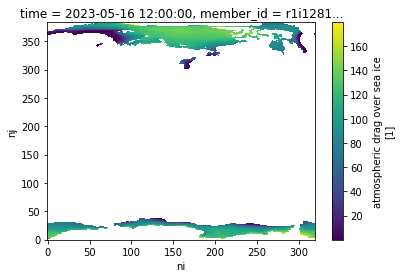

In [ ]:
sidragtop_le.sel(member_id='r1i1281p1f1').isel(time=100).plot()

In [ ]:
#mask just where aice>15%
sidragtop_masked_le = sidragtop_le.where(aice_le >= 0.15)

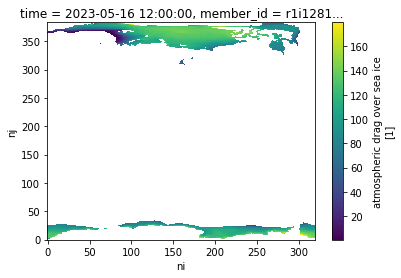

In [ ]:
# test simple plot
sidragtop_masked_le.sel(member_id='r1i1281p1f1').isel(time=100).plot()

## Set a mask for region of interest

In [ ]:
# Load in masks
mask_in = ['nh_mask', 'Lab_mask', 'GIN_mask', 'Bar_mask', 'ArcOc_mask', 'Sib_mask', 'Beau_mask', 'Bering_mask', 'Hudson_mask', 'CAArch_mask', 'Okhotsk_mask']

ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/masks/REGION_MASK_gx1v7.nc')
ds_masks=ds_masks.rename({'lat':'nj','lon': 'ni'})
my_mask = ds_masks[mask_in].isel(time=0)

# now load in the different masks as a new coordinate
masks=xr.concat([my_mask.nh_mask,my_mask.Lab_mask,my_mask.GIN_mask,my_mask.Bar_mask,my_mask.ArcOc_mask,my_mask.Sib_mask,my_mask.Beau_mask,my_mask.Bering_mask,my_mask.Hudson_mask,my_mask.CAArch_mask,my_mask.Okhotsk_mask],dim='region')
masks['region']=mask_in

/glade/work/duvivier/miniconda3/envs/analysis2/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'Lab_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/analysis2/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'GIN_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/analysis2/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'Bar_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/analysis2/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'ArcOc_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade

In [ ]:
# read in two relevant masks
reg1 = 'ArcOc_mask'
reg2 = 'Bar_mask'
reg = reg1+'_and_'+reg2
mask_both = masks.sel(region=reg1).fillna(0) + masks.sel(region=reg2).fillna(0)
mask_both = mask_both.where(mask_both == 1)

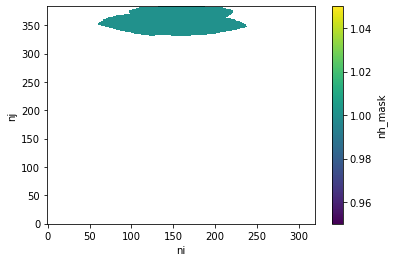

In [ ]:
mask_both.plot()

## Actually mask just central Arctic Ocean

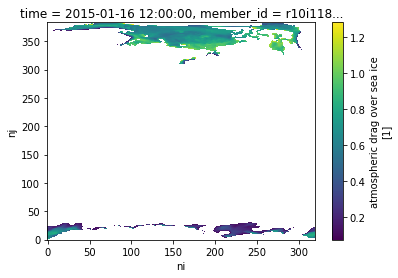

In [ ]:
sidragtop_masked_le.isel(member_id=0,time=0).plot()

In [ ]:
# mask the data
sidragtop_masked_le = sidragtop_masked_le.where(masks.sel(region=reg1) == 1)
sidragtop_masked_smooth = sidragtop_masked_smooth.where(masks.sel(region=reg1) == 1)

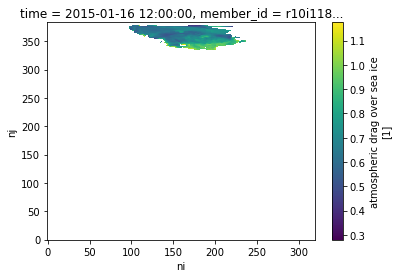

In [ ]:
sidragtop_masked_le.isel(member_id=0,time=0).plot()

In [ ]:
# now just keep the NH points
sidragtop_masked_le = sidragtop_masked_le.isel(nj=slice(300,384))
sidragtop_masked_smooth = sidragtop_masked_smooth.isel(nj=slice(300,384))

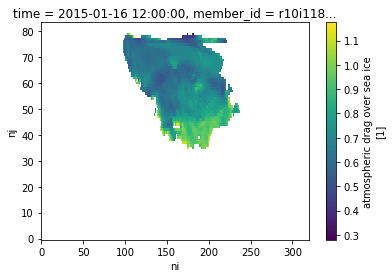

In [ ]:
sidragtop_masked_le.isel(member_id=0,time=0).plot()

## Subset dates

In [ ]:
# Keep just the March data
sidragtop_le_march = sidragtop_masked_le.isel(time=sidragtop_masked_le.time.dt.month.isin([3]))
sidragtop_smooth_march = sidragtop_masked_smooth.isel(time=sidragtop_masked_smooth.time.dt.month.isin([3]))

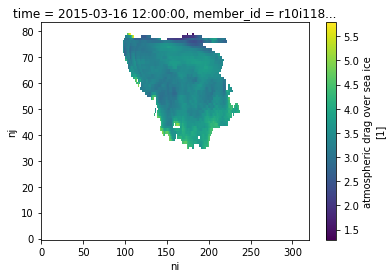

In [ ]:
sidragtop_le_march.isel(member_id=0,time=0).plot()

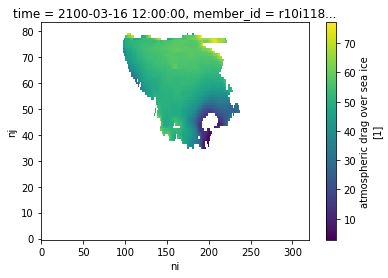

In [ ]:
sidragtop_le_march.isel(member_id=0,time=85).plot()

In [ ]:
sidragtop_le_march

,Array,Chunk
Bytes,440.92 MiB,1.03 MiB
Shape,"(50, 86, 84, 320)","(1, 10, 84, 320)"
Count,6807 Tasks,450 Chunks
Type,float32,numpy.ndarray


## Calculate decadal and ensemble means

In [ ]:
sidragtop_le_march.time.dt.year

<xarray.DataArray 'year' (time: 86)>
array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025,
       2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036,
       2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047,
       2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058,
       2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069,
       2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080,
       2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091,
       2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100])
Coordinates:
  * time     (time) object 2015-03-16 12:00:00 ... 2100-03-16 12:00:00
    region   <U12 'ArcOc_mask'

In [ ]:
#specify some arrays that will become coordinate arrays
decades = list(range(2010,2100,10))
decade_names = ['2010','2020','2030','2040','2050','2060','2070','2080','2090']

In [ ]:
# Loop through decades - rufmod
print('Calculating Decadal and Ensemble Means - SMOOTH')

# make numpy array to fill and specify dimensions we want
array_smooth = np.zeros([len(decades),len(sidragtop_smooth_march.nj),len(sidragtop_smooth_march.ni)])

# decade loop
for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 2010:
        count = 0
    else: 
        count = count+1
    # set the start and end years for this decade
    yy_st = dec
    yy_ed = yy_st + 10
    yy = list(range(yy_st,yy_ed,1))
    # subset the data for these years only but keep all months
    temp1 = sidragtop_smooth_march.isel(time=sidragtop_smooth_march.time.dt.year.isin([yy]))
    # stack so we can average over years and ensembles at once
    temp2 = temp1.stack(all_times=("time","member_id"))
    # average over everything
    array_smooth[count,:,:] = temp2.mean(dim='all_times')
        

Calculating Decadal and Ensemble Means - SMOOTH
Calculating decadal means for 2010s
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


In [ ]:
# Loop through decades - CESM2-LE
print('Calculating Decadal and Ensemble Means - CESM2-LE')

# make numpy array to fill and specify dimensions we want
array_le = np.zeros([len(decades),len(sidragtop_le_march.nj),len(sidragtop_le_march.ni)])

# decade loop
for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 2010:
        count = 0
    else: 
        count = count+1
    # set the start and end years for this decade
    yy_st = dec
    yy_ed = yy_st + 10
    yy = list(range(yy_st,yy_ed,1))
    # subset the data for these years only but keep all months
    temp1 = sidragtop_le_march.isel(time=sidragtop_le_march.time.dt.year.isin([yy]))
    # stack so we can average over years and ensembles at once
    temp2 = temp1.stack(all_times=("time","member_id"))
    # average over everything
    array_le[count,:,:] = temp2.mean(dim='all_times')
        

Calculating Decadal and Ensemble Means - CESM2-LE
Calculating decadal means for 2010s
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


In [ ]:
# convert the numpy array to a xarray for easier plotting
sidragtop_march_dec_le = xr.DataArray(array_le,dims=('decades','nj','ni'))
sidragtop_march_dec_smooth = xr.DataArray(array_smooth,dims=('decades','nj','ni'))

In [ ]:
# set coordinate arrays
sidragtop_march_dec_le['decades'] = decade_names
sidragtop_march_dec_le['nj'] = sidragtop_le_march['nj'].values
sidragtop_march_dec_le['ni'] = sidragtop_le_march['ni'].values

sidragtop_march_dec_smooth['decades'] = decade_names
sidragtop_march_dec_smooth['nj'] = sidragtop_le_march['nj'].values
sidragtop_march_dec_smooth['ni'] = sidragtop_le_march['ni'].values

## Plotting

### General plotting data

In [ ]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [ ]:
# get pop grid for lat/lon values
grid = pop_tools.get_grid('POP_gx1v7')
# assign lat/lon data
TLONG = grid.TLONG
TLAT = grid.TLAT

In [ ]:
# Keep only NH points
TLONG_sub = TLONG.isel(nlat=slice(300,384))
TLAT_sub = TLAT.isel(nlat=slice(300,384))

### Regrid so we can plot contours properly

In [ ]:
# rename lat and lon coordinates
TLAT_sub = TLAT_sub.rename({'nlon':'ni','nlat':'nj'})
TLONG_sub = TLONG_sub.rename({'nlon':'ni','nlat':'nj'})

In [ ]:
# Set the lon and lat fields to be the POP lats and lons
# if there are no variables in the dataset named 'TLON' and 'TLAT' already they will now be created
sidragtop_march_dec_le['TLON']=TLONG_sub
sidragtop_march_dec_le['TLAT']=TLAT_sub

sidragtop_march_dec_smooth['TLON']=TLONG_sub
sidragtop_march_dec_smooth['TLAT']=TLAT_sub

In [ ]:
#Now rename TLON and TLAT to be lon and lat
sidragtop_march_dec_le=sidragtop_march_dec_le.rename({'TLON':'lon','TLAT':'lat'})
sidragtop_march_dec_smooth=sidragtop_march_dec_smooth.rename({'TLON':'lon','TLAT':'lat'})

In [ ]:
# Setting up a target grid to only regrid data in the northern hemisphere north of ~50N
#Start at ~50N, but do not include 90N otherwise cartopy gets rage-y (i.e. it doesn't work) when plotting
lat=np.arange(49.4,90.0,0.5) 
lon=np.arange(0.0,361.0,1.0)
#create a meshgrid (2D fields of lats and lons)
lon2d,lat2d=np.meshgrid(lon,lat) 
#set up the target grid as an xarray Dataset
target_grid=xr.Dataset({'lat': (['y', 'x'], lat2d),'lon': (['y', 'x'], lon2d)})

In [ ]:
#input grid, output grid, method, keyword arguments
regridder=xe.Regridder(sidragtop_march_dec_le, target_grid, 'nearest_s2d',periodic=True,reuse_weights=False)

/glade/work/duvivier/miniconda3/envs/analysis2/lib/python3.7/site-packages/xarray/core/dataarray.py:784: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [ ]:
# actually do the regridding
sidragtop_march_dec_le_regrid=regridder(sidragtop_march_dec_le)
sidragtop_march_dec_smooth_regrid=regridder(sidragtop_march_dec_smooth)

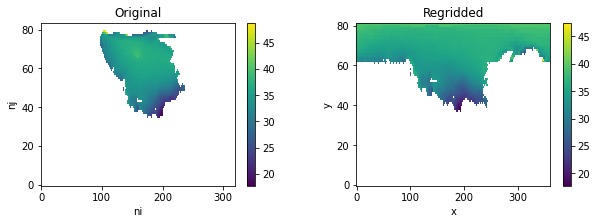

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(10,3))
axs=ax.flatten()
sidragtop_march_dec_le.sel(decades='2010').plot(ax=axs[0])
axs[0].set_title('Original')
sidragtop_march_dec_le_regrid.sel(decades='2010').plot(ax=axs[1])
axs[1].set_title('Regridded')
plt.subplots_adjust(wspace=0.3)

### Now Plot - spatial plots by decade

Plotting drag for 2010


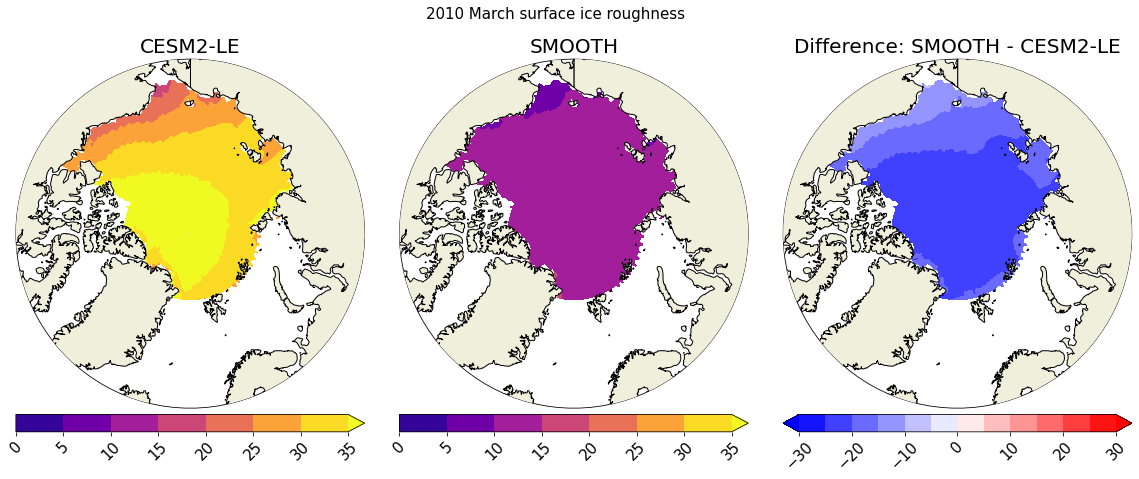

In [ ]:
# set units
units = ''

sidragtop_march_dec_le_regrid

#Plot each season and percent difference
levels_in = np.arange(0,40,5)
cmap_in = plt.cm.get_cmap('plasma')
levels_diff = np.arange(-30,35,5)
cmap_diff = plt.cm.get_cmap('bwr')

for dd in decade_names[0:1]:
    print('Plotting drag for '+dd)
    # grab data to plot
    temp_le = sidragtop_march_dec_le_regrid.sel(decades=dd)
    temp_smooth = sidragtop_march_dec_smooth_regrid.sel(decades=dd)
    
    # calculate difference
    diff = temp_smooth - temp_le
           
    # create figure
    fig = plt.figure(figsize=(20,20))
    fout = 'fig_1_'+var_in_1+'_march_'+dd+'s'
    title = dd+' March surface ice roughness'
     
    # Make subplots - note it's nrow x ncol x index (starting upper left)
    ### First subplot: CESM2-LE
    ax = fig.add_subplot(1,3,1, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    # plot this month's trends
    this=ax.contourf(temp_le.lon,temp_le.lat,
                     temp_le,
                     cmap = cmap_in,                      
                     levels=levels_in,extend='max',
                     transform=ccrs.PlateCarree())
    # add colorbar
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel(units, fontsize=15)
    plt.title('CESM2-LE',fontsize=20)
    
    ### Second subplot: CESM2-LE
    ax = fig.add_subplot(1,3,2, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(temp_smooth.lon,temp_smooth.lat,
                     temp_smooth,
                     cmap = cmap_in,                      
                     levels=levels_in,extend='max',
                     transform=ccrs.PlateCarree())
    # add colorbar 
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel(units, fontsize=15)
    plt.title('SMOOTH',fontsize=20)

    # Third subplot: Diff
    ax = fig.add_subplot(1,3,3, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    # plot % diffs
    this=ax.contourf(diff.lon,diff.lat,
                     diff,
                     cmap = cmap_diff,                      
                     levels=levels_diff, extend='both',
                     transform=ccrs.PlateCarree()) 
    # add colorbar
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel(units, fontsize=15)
    plt.title('Difference: SMOOTH - CESM2-LE',fontsize=20)
    
    # Finalize figure and save
    fig.suptitle(title,fontsize=15, y=0.75)  
    fig.subplots_adjust(bottom=0.45,wspace=0.1)
    #fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)  


Plotting drag for 2010


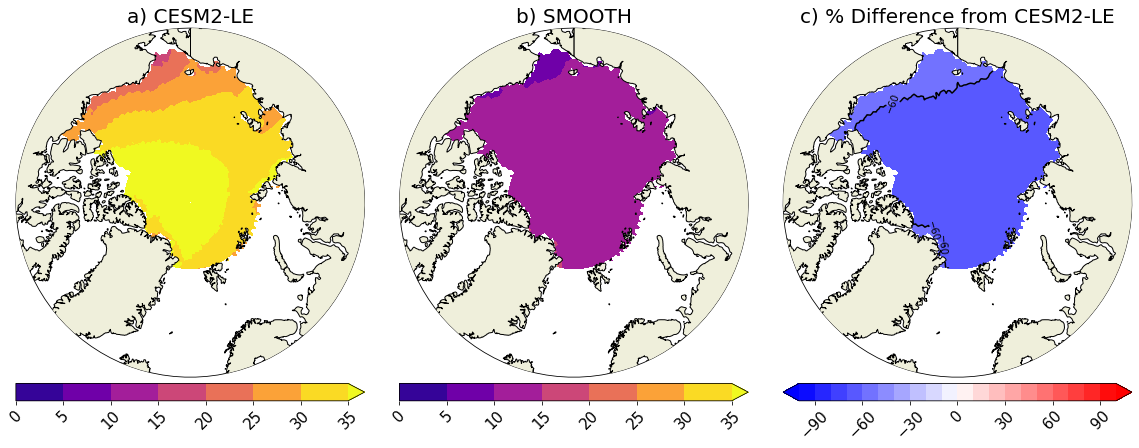

In [65]:
# set units
units = ''

sidragtop_march_dec_le_regrid

#Plot each season and percent difference
levels_in = np.arange(0,40,5)
cmap_in = plt.cm.get_cmap('plasma')
levels_diff = np.arange(-100,110,10)
cmap_diff = plt.cm.get_cmap('bwr')

for dd in decade_names[0:1]:
    print('Plotting drag for '+dd)
    # grab data to plot
    temp_le = sidragtop_march_dec_le_regrid.sel(decades=dd)
    temp_smooth = sidragtop_march_dec_smooth_regrid.sel(decades=dd)
    
    # calculate difference
    diff = 100*((temp_smooth - temp_le)/temp_le)
           
    # create figure
    fig = plt.figure(figsize=(20,20))
    fout = 'fig_1_'+var_in_1+'_march_'+dd+'s'
    title = dd+' March surface ice roughness'
     
    # Make subplots - note it's nrow x ncol x index (starting upper left)
    ### First subplot: CESM2-LE
    ax = fig.add_subplot(1,3,1, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    # plot this month's trends
    this=ax.contourf(temp_le.lon,temp_le.lat,
                     temp_le,
                     cmap = cmap_in,                      
                     levels=levels_in,extend='max',
                     transform=ccrs.PlateCarree())
    # add colorbar
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel(units, fontsize=15)
    plt.title('a) CESM2-LE',fontsize=20)
    
    ### Second subplot: CESM2-LE
    ax = fig.add_subplot(1,3,2, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(temp_smooth.lon,temp_smooth.lat,
                     temp_smooth,
                     cmap = cmap_in,                      
                     levels=levels_in,extend='max',
                     transform=ccrs.PlateCarree())
    # add colorbar 
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel(units, fontsize=15)
    plt.title('b) SMOOTH',fontsize=20)

    # Third subplot: Diff
    ax = fig.add_subplot(1,3,3, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    # plot % diffs
    this=ax.contourf(diff.lon,diff.lat,
                     diff,
                     cmap = cmap_diff,                      
                     levels=levels_diff, extend='both',
                     transform=ccrs.PlateCarree()) 
    # add contour lines and labels
    this2=ax.contour(diff.lon,diff.lat,
                       diff,
                       colors='black',linestyles='solid',levels=levels_diff,
                       transform=ccrs.PlateCarree())    
    plt.gca().clabel(this2,this2.levels[::2], inline=True, fontsize=10, colors='black') 
    # add colorbar
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel(units, fontsize=15)
    plt.title('c) % Difference from CESM2-LE',fontsize=20)
    
    # Finalize figure and save
    #fig.suptitle(title,fontsize=15, y=0.75)  
    fig.subplots_adjust(bottom=0.45,wspace=0.1)
    fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)  
